In [2]:
# Imports

import os
import pickle
import gc

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import wilcoxon
from scipy.stats import pearsonr
from processing_session_trajectory import *


In [3]:
path_to_data_folder = '/home/david/MyLocalData/Maud/'
pattern_of_MOU_Folders = os.path.join(path_to_data_folder, "MOU*")

mice_list: list[str] = ["MOU3867","MOU4551","MOU4562","MOU4560","MOU4623","MOU4624","MOU4552","MOU4563","MOU4561","MOU4692",
                        "MOU4695","MOU4698","MOU4703","MOU4175","MOU4988","MOU4964","MOU4965","MOU4986","MOU5007"]

session_list = {}
for mouse in mice_list:
    mouse_folder = os.path.join(path_to_data_folder,mouse)
    session_list[mouse] = sorted([name for name in os.listdir(mouse_folder)
                           if os.path.isdir(os.path.join(mouse_folder, name))
                           and name.startswith('MOU')])
    nb_sessions = len(session_list[mouse])
    # print(f'Hello, I\'m {mouse}! I have foraged for {nb_sessions} sessions')

#MOU4993 ? No effect of CNO

In [ ]:
# Define groups
UL_Gq_D1_DLS: list[str] = ["MOU4551","MOU4988"]
UL_Gq_D2_DLS: list[str] = ["MOU4562","MOU4560"]
UL_Gq_D1_DMS: list[str] = ["MOU4624","MOU4552","MOU4703","MOU3867","MOU4986","MOU5007","MOU4623"]
UL_Gq_D2_DMS: list[str] = ["MOU4563","MOU4561","MOU4695","MOU4698","MOU4692","MOU4964","MOU4965","MOU4175"]

groups = {
    "D1 DLS": UL_Gq_D1_DLS,
    "D2 DLS": UL_Gq_D2_DLS,
    "D1 DMS": UL_Gq_D1_DMS,
    "D2 DMS": UL_Gq_D2_DMS
}

# Define lists according to first CNO congruence
batch_starting_incongruent: list[str] = ['MOU3867','MOU4175','MOU4551','MOU4552','MOU4560','MOU4561','MOU4562',
                                         'MOU4563','MOU4623','MOU4624','MOU4692','MOU4695','MOU4698','MOU4703']
batch_starting_congruent: list[str] = ['MOU4988','MOU4993','MOU4964','MOU4965','MOU4986','MOU5007']

bias_to_rewarded_direction: list[str] = ['incongruent','congruent','mixed']

# Define CNO sessions indices
session_cno_indices = {
    "cno_first": 20,
    "cno_second": 30,
    "cno_third": 42
}

# Colormaps dictionary
colormaps = {
    "D1 DLS": "Greens",
    "D2 DLS": "Oranges",
    "D1 DMS": "Blues",
    "D2 DMS": "RdPu"
}

In [ ]:
# Define dictionaries to store pickle results per session and per mouse
positions_cm_dict = {}
X_positions_dict = {}
Y_positions_dict = {}
total_distances = {}
average_speeds = {}
distances_dict = {}
speeds_dict = {}
angular_speeds_dict = {}
all_epochs_dict = {}
traject_time_dict = {}
run_around_tower_results_dict = {}
runs_around_tower_dict = {}
trapezes_coordinates_dict = {}
towers_coordinates_dict = {}
runs_between_towers_dict = {}
exploratory_runs_dict = {}
time_border_dict = {}
time_interior_dict = {}
time_trapeze_dict = {}
distance_border_dict = {}
distance_interior_dict = {}
distance_trapeze_dict = {}
ratio_time_trapeze_over_border = {}
ratio_distance_trapeze_over_border = {}
time_trapeze_minus_border = {}
distance_trapeze_minus_border = {}

# Loop to process each mouse
for mouse in mice_list:
    
    # Initialize subdictionaries for each mouse
    positions_cm_dict[mouse] = {}
    X_positions_dict[mouse] = {}
    Y_positions_dict[mouse] = {}
    total_distances[mouse] = {}
    average_speeds[mouse] = {}
    distances_dict[mouse] = {}
    speeds_dict[mouse] = {}
    angular_speeds_dict[mouse] = {}
    all_epochs_dict[mouse] = {}
    traject_time_dict[mouse] = {}
    run_around_tower_results_dict[mouse] = {}
    runs_around_tower_dict[mouse] = {}
    trapezes_coordinates_dict[mouse] = {}
    towers_coordinates_dict[mouse] = {}
    runs_between_towers_dict[mouse] = {}
    exploratory_runs_dict[mouse] = {}
    time_border_dict[mouse] = {}
    time_interior_dict[mouse] = {}
    time_trapeze_dict[mouse] = {}
    distance_border_dict[mouse] = {}
    distance_interior_dict[mouse] = {}
    distance_trapeze_dict[mouse] = {}
    ratio_time_trapeze_over_border[mouse] = {}
    ratio_distance_trapeze_over_border[mouse] = {}
    time_trapeze_minus_border[mouse] = {}
    distance_trapeze_minus_border[mouse] = {}

    for session_index, session_name in enumerate(session_list[mouse]):
        
        output_pickle_filepath = os.path.join(path_to_data_folder, mouse, session_name, f"{session_name}_basic_processing_output.pickle")

        if not os.path.exists(output_pickle_filepath):
            print(f"Erreur : le fichier {output_pickle_filepath} n'existe pas.")
            continue
        elif os.path.getsize(output_pickle_filepath) == 0:
            print(f"Erreur : le fichier {output_pickle_filepath} est vide.")
            continue

        # Loading data from the pickle
        try:
            with open(output_pickle_filepath, 'rb') as f:
                data = pickle.load(f)
        except EOFError:
            print(f"Erreur de lecture : le fichier {output_pickle_filepath} semble être corrompu.")
            continue

        # Data extraction
        positions_cm = data['positions']
        X_positions_cm = data['positions'][0]
        Y_positions_cm = data['positions'][1]
        average_speed = data['average_speed']
        distances = data['distances']
        speeds = data['speeds']
        angular_speeds = data['angular_speeds']
        all_epochs = data['all_epochs']
        traject_time = data['timeofframes']
        run_around_tower_results = data['run_around_tower_sessionresult']
        runs_around_tower = all_epochs['run_around_tower']
        runs_between_towers = all_epochs['run_between_towers']
        exploratory_runs = all_epochs['exploratory_run']
        trapezes_coordinates = data['all_trapezes_coordinates_cm']
        towers_coordinates = data['towers_coordinates_cm']
        time_border = data['time_in_zones']['border']
        time_interior = data['time_in_zones']['interior']
        time_trapeze = data['time_in_zones']['trapeze']
        distance_border = data['distance_in_zones']['border']
        distance_interior = data['distance_in_zones']['interior']
        distance_trapeze = data['distance_in_zones']['trapeze']

        # Calculation of total distance in meters
        total_distance = np.sum(distances) / 100

        # Storing in full dictionaries using session index
        positions_cm_dict[mouse][session_index] = positions_cm
        X_positions_dict[mouse][session_index] = X_positions_cm
        Y_positions_dict[mouse][session_index] = Y_positions_cm
        total_distances[mouse][session_index] = total_distance
        average_speeds[mouse][session_index] = average_speed
        distances_dict[mouse][session_index] = distances
        speeds_dict[mouse][session_index] = speeds
        angular_speeds_dict[mouse][session_index] = angular_speeds
        all_epochs_dict[mouse][session_index] = all_epochs
        traject_time_dict[mouse][session_index] = traject_time
        run_around_tower_results_dict[mouse][session_index] = run_around_tower_results
        runs_around_tower_dict[mouse][session_index] = runs_around_tower
        trapezes_coordinates_dict[mouse][session_index] = trapezes_coordinates
        towers_coordinates_dict[mouse][session_index] = towers_coordinates
        runs_between_towers_dict[mouse][session_index] = runs_between_towers
        exploratory_runs_dict[mouse][session_index] = exploratory_runs
        time_border_dict[mouse][session_index] = time_border
        time_interior_dict[mouse][session_index] = time_interior
        time_trapeze_dict[mouse][session_index] = time_trapeze
        distance_border_dict[mouse][session_index] = distance_border
        distance_interior_dict[mouse][session_index] = distance_interior
        distance_trapeze_dict[mouse][session_index] = distance_trapeze

        if time_border == 0:
            ratio_time_trapeze_over_border[mouse][session_index] = 0
        else:
            ratio_time_trapeze_over_border[mouse][session_index] = time_trapeze/time_border

        if distance_border == 0:
            ratio_distance_trapeze_over_border[mouse][session_index] = 0
        else:
            ratio_distance_trapeze_over_border[mouse][session_index] = distance_trapeze/distance_border

        time_trapeze_minus_border[mouse][session_index] = time_trapeze - time_border
        distance_trapeze_minus_border[mouse][session_index] = distance_trapeze - distance_border


# print(time_zones_dict['MOU3867'][25]['border']) # Example of how to call a dictionnary

## Basic metrics and runs around towers (QT) analysis

#### Compare metrics between groups and before/after CNO injection.

D2 DMS Incongruent (Totale distance (m)) - Statistique de Wilcoxon: 1.0, p-value: 0.0156
D2 DMS Incongruent (Average speed (cm/s)) - Statistique de Wilcoxon: 1.0, p-value: 0.0156


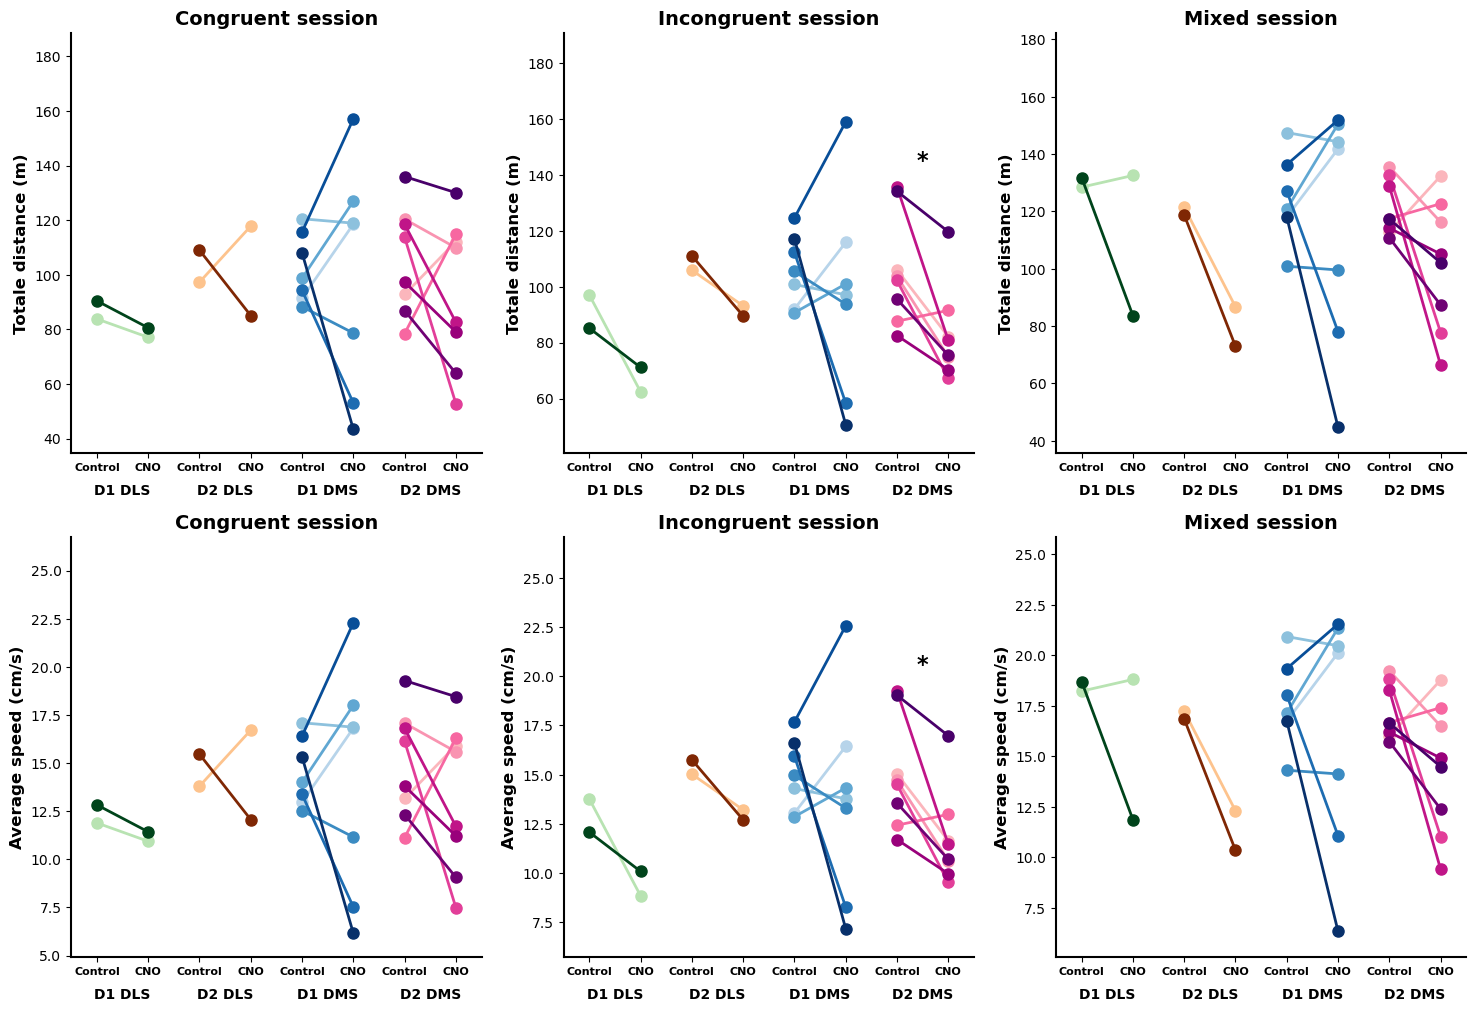

In [ ]:
# Function to compare a metric between groups before and after CNO injection

def plot_metric_comparison_by_group(ax, metric_dict, metric_name, groups, set_title=True, bias_direction="congruent"):
    """
    Compares a metric before and after CNO injection for each group, with improved display.
    
    :param ax: Matplotlib axis on which to draw the graph.
    :param metric_dict: Dictionary of metrics for each mouse.
    :param metric_name: Name of the metric to display on the Y axis.
    :param groups: Mouse group dictionary (group name → list of mice).
    :param bias_direction: "congruent", "incongruent" ou "mixed".
    """

    # Definition of CNO sessions and control based on condition
    if bias_direction == "Mixed":
        session_cno_selected = {mouse: session_cno_indices["cno_third"] for mouse in mice_list}
    else:
        session_cno_selected = {
            mouse: session_cno_indices["cno_second"] if mouse in batch_starting_incongruent 
            else session_cno_indices["cno_first"]
            for mouse in mice_list
        } if bias_direction == "Congruent" else {
            mouse: session_cno_indices["cno_first"] if mouse in batch_starting_incongruent 
            else session_cno_indices["cno_second"]
            for mouse in mice_list
        }

    session_control_selected = {mouse: idx - 4 for mouse, idx in session_cno_selected.items()}

    tick_positions = []
    session_labels = []
    group_annotations = []
    
    all_data = []
    wilcoxon_results = {}

    # Loop through each group to retrieve the data and plot the points
    for i, (group_name, group_mice) in enumerate(groups.items()):
        group_control_data = []
        group_cno_data = []
        
        cmap = plt.get_cmap(colormaps.get(group_name))  # Group specific colormap
        colors = cmap(np.linspace(0.3, 1, len(group_mice)))  # Color gradient for group mice
        
        for j, mouse in enumerate(group_mice):
            if mouse in metric_dict:
                if session_control_selected[mouse] in metric_dict[mouse] and session_cno_selected[mouse] in metric_dict[mouse]:
                    before = metric_dict[mouse][session_control_selected[mouse]]
                    after = metric_dict[mouse][session_cno_selected[mouse]]

                    group_control_data.append(before)
                    group_cno_data.append(after)
                    all_data.extend([before, after])

                    # Position on the X axis
                    control_position = i * 2
                    cno_position = i * 2 + 1

                    # Drawing lines and points
                    ax.plot([control_position, cno_position], [before, after], color=colors[j], linewidth=2, linestyle='-', marker='o', markersize=8)

        # 🔬 Wilcoxon test for D1 DMS and D2 DMS (only those groups for now because of the N)
        if group_name in ["D1 DMS", "D2 DMS"] and len(group_control_data) > 0 and len(group_cno_data) > 0:
            stat, p_value = wilcoxon(group_control_data, group_cno_data)
            wilcoxon_results[group_name] = {"statistic": stat, "p_value": p_value}

            # 🌟 Display a star (*) if p-value ≤ 0.05
            if p_value <= 0.05:
                max_value = max(max(group_control_data), max(group_cno_data))
                ax.text((control_position + cno_position) / 2, max_value * 1.05, "*", 
                        fontsize=16, fontweight='bold', ha='center', color='black')

        # Added positions and labels for the X axis
        tick_positions.extend([i * 2, i * 2 + 1])
        session_labels.extend(["Control", "CNO"])

        # Add group annotation
        group_annotations.append((i * 2 + 0.5, group_name))

    # Axis configuration
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(session_labels, fontsize=10, fontweight='bold')

    # Displaying group names below pairs of points
    for pos, group_name in group_annotations:
        ax.annotate(group_name, xy=(pos, -0.1), xycoords=('data', 'axes fraction'), ha='center', fontsize=10, fontweight='bold')

    if set_title:
        ax.set_title(f"{bias_direction} session", fontsize=14, fontweight='bold')
    ax.set_ylabel(metric_name, fontsize=12, fontweight='bold')

    # Automatic definition of ylim with a 20% margin
    if all_data:
        ax.set_ylim(min(all_data)*0.8, max(all_data) * 1.2)

    ax.set_xlim(-0.5, len(groups) * 2 - 0.5)

    # Removed grids for a cleaner display
    ax.grid(False)

    # Customizing the axes
    ax.tick_params(axis='y', which='major', labelsize=10)
    ax.tick_params(axis='x', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    # Displaying results in the console
    for group, result in wilcoxon_results.items():
        if result['p_value'] <= 0.05:
            print(f"{group} {bias_direction} ({metric_name}) - Statistique de Wilcoxon: {result['statistic']}, p-value: {result['p_value']:.4f}")

# Example of use
fig, axs = plt.subplots(2,3,figsize=(18, 12))
plot_metric_comparison_by_group(axs[0,0], total_distances, "Totale distance (m)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[0,1], total_distances, "Totale distance (m)", groups, bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[0,2], total_distances, "Totale distance (m)", groups, bias_direction="Mixed")

plot_metric_comparison_by_group(axs[1,0], average_speeds, "Average speed (cm/s)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1,1], average_speeds, "Average speed (cm/s)", groups, bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[1,2], average_speeds, "Average speed (cm/s)", groups, bias_direction="Mixed")

plt.show()


In [ ]:
# Retrieve distance, time, mean speed, max speed
# Initialize counters and lists for run analysis

total_time_QT_dict = {}
total_distance_QT_dict = {}
meanspeed_QT_dict = {}
maxspeed_QT_dict = {}

for mouse in mice_list:
    total_time_QT_dict[mouse] = {}
    total_distance_QT_dict[mouse] = {}
    meanspeed_QT_dict[mouse] = {}
    maxspeed_QT_dict[mouse] = {}

    for session_index, session_name in enumerate(session_list[mouse]):

            total_time_QT = 0
            total_distance_QT = 0
            speed_QT = []

            for run in runs_around_tower_dict[mouse][session_index]:
                start_index, end_index = run[0][0], run[0][1]
                run_duration = traject_time_dict[mouse][session_index][end_index] - traject_time_dict[mouse][session_index][start_index]
                distance_ran = np.sum(distances_dict[mouse][session_index][start_index:end_index])

                # Accumulate metrics
                speed_QT.append(distance_ran / run_duration)
                total_time_QT += run_duration
                total_distance_QT += distance_ran

            # Store results for this session in the dictionaries
            meanspeed_QT_dict[mouse][session_index] = np.mean(speed_QT)
            maxspeed_QT_dict[mouse][session_index] = np.max(speed_QT)
            total_time_QT_dict[mouse][session_index] = round(total_time_QT, 2)
            total_distance_QT_dict[mouse][session_index] = round(total_distance_QT, 2)

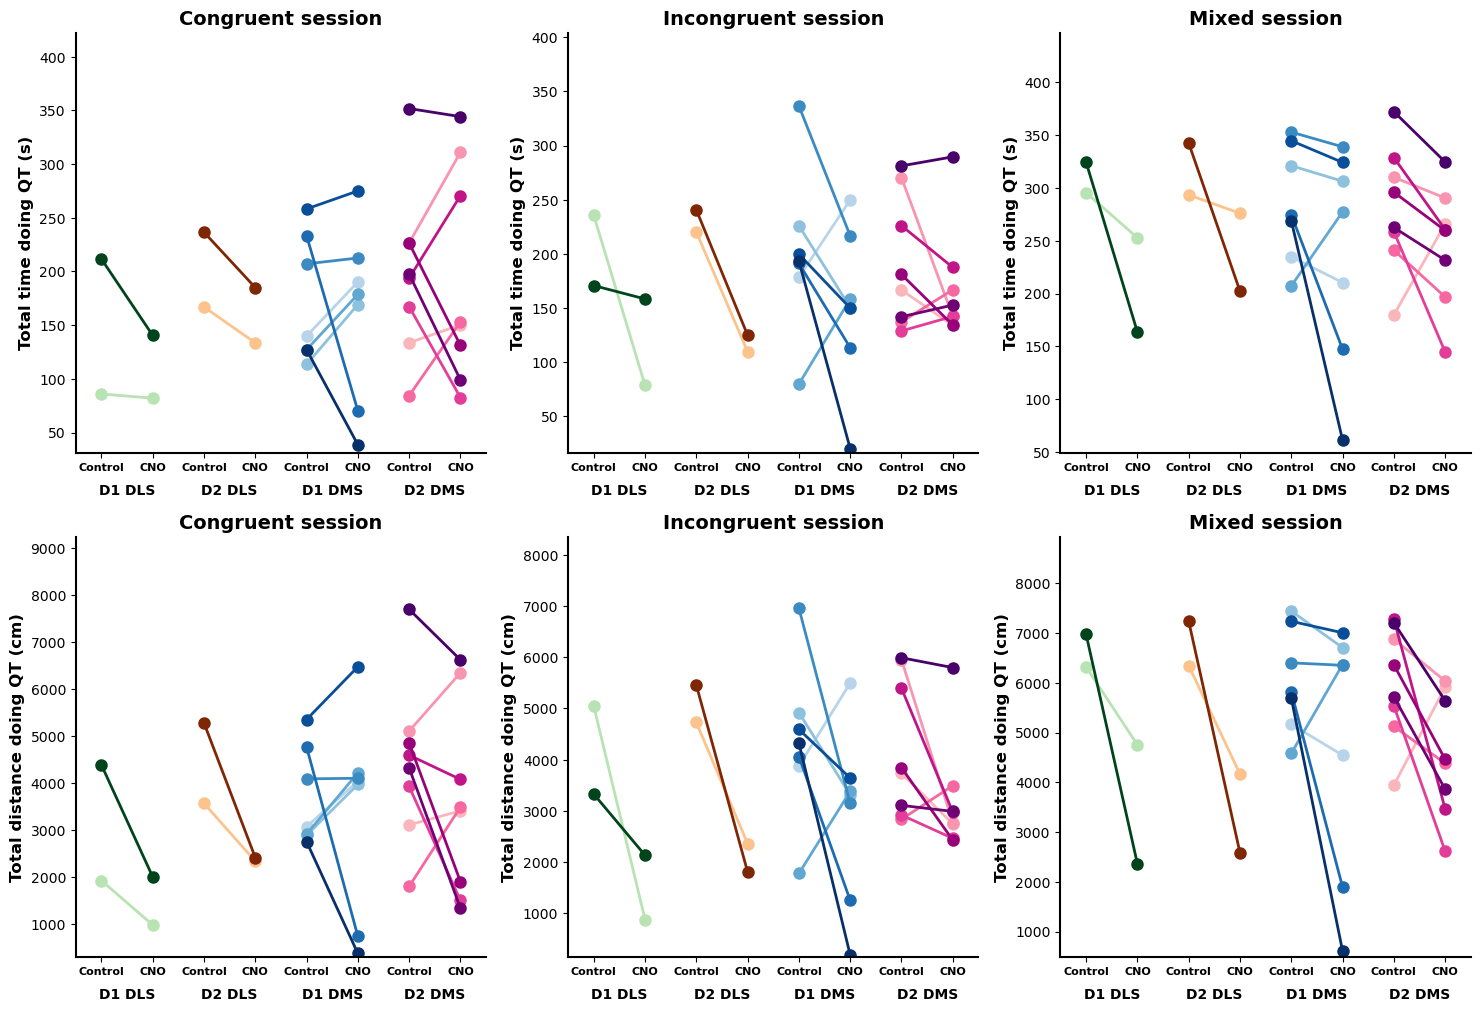

In [ ]:
# Plot time/distance of runs around towers with plot_metric_comparison_by_group

fig, axs = plt.subplots(2,3,figsize=(18, 12))
plot_metric_comparison_by_group(axs[0,0], total_time_QT_dict, "Total time doing QT (s)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[0,1], total_time_QT_dict, "Total time doing QT (s)", groups, bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[0,2], total_time_QT_dict, "Total time doing QT (s)", groups, bias_direction="Mixed")

plot_metric_comparison_by_group(axs[1,0], total_distance_QT_dict, "Total distance doing QT (cm)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1,1], total_distance_QT_dict, "Total distance doing QT (cm)", groups, bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[1,2], total_distance_QT_dict, "Total distance doing QT (cm)", groups, bias_direction="Mixed")

plt.show()

D2 DMS Congruent (Mean speed of QT (cm/s)) - Statistique de Wilcoxon: 2.0, p-value: 0.0234
D2 DMS Incongruent (Mean speed of QT (cm/s)) - Statistique de Wilcoxon: 0.0, p-value: 0.0078
D2 DMS Mixed (Mean speed of QT (cm/s)) - Statistique de Wilcoxon: 3.0, p-value: 0.0391
D2 DMS Incongruent (Max speed of QT (cm/s)) - Statistique de Wilcoxon: 2.0, p-value: 0.0234
D2 DMS Mixed (Max speed of QT (cm/s)) - Statistique de Wilcoxon: 1.0, p-value: 0.0156


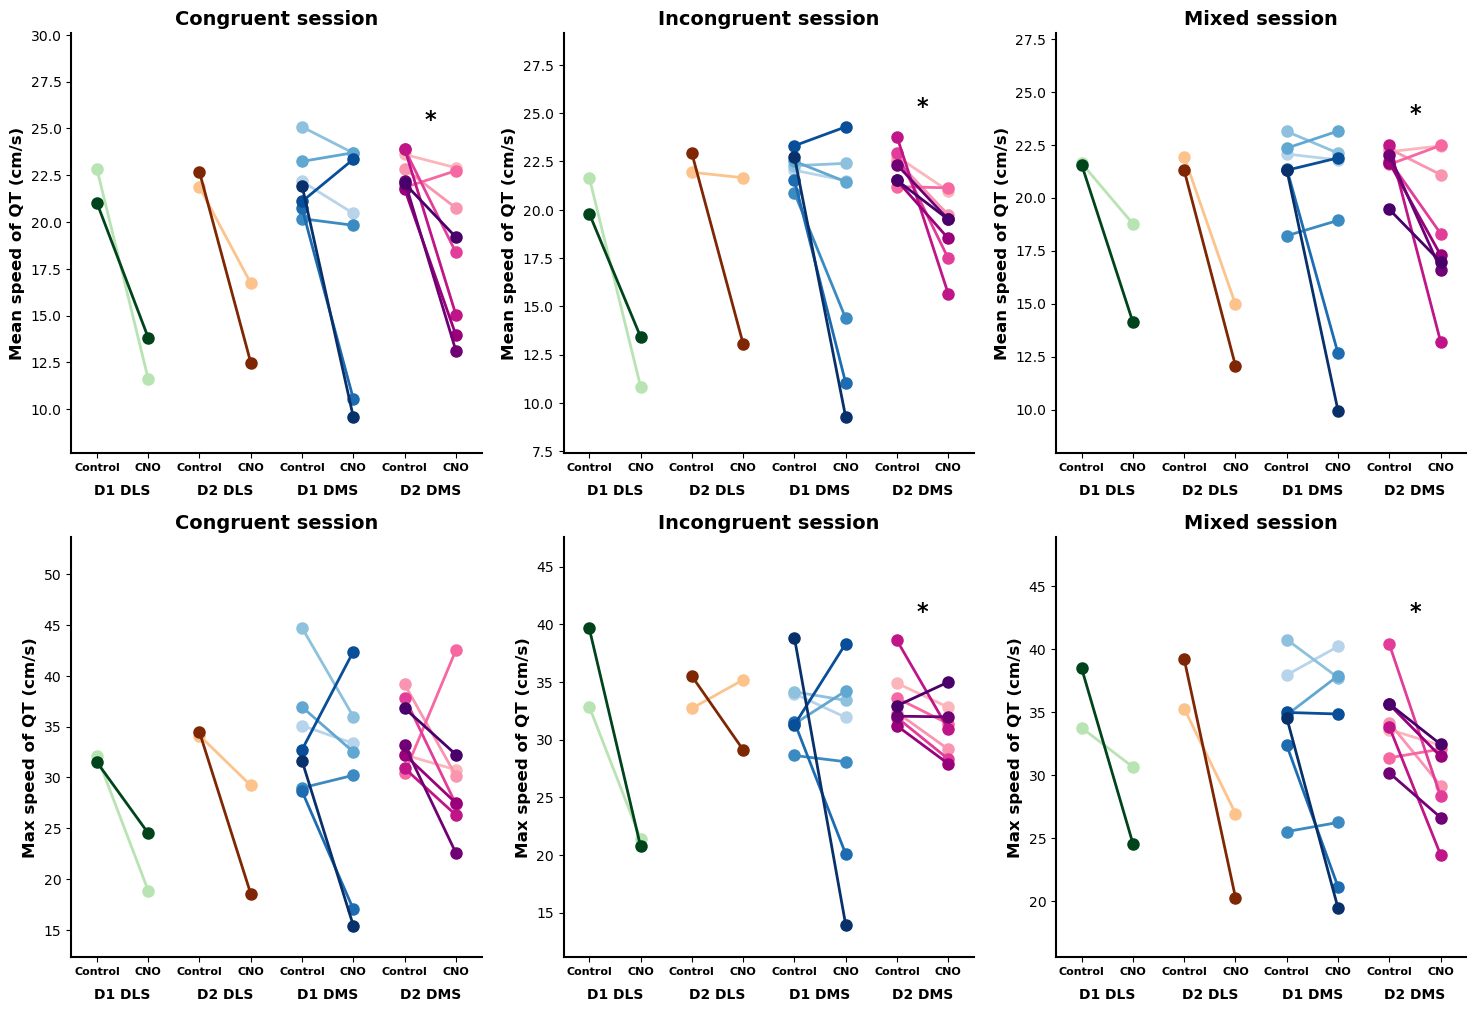

In [ ]:
# Plot speeds of runs around towers with plot_metric_comparison_by_group

fig, axs = plt.subplots(2,3,figsize=(18, 12))
plot_metric_comparison_by_group(axs[0,0], meanspeed_QT_dict, "Mean speed of QT (cm/s)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[0,1], meanspeed_QT_dict, "Mean speed of QT (cm/s)", groups, bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[0,2], meanspeed_QT_dict, "Mean speed of QT (cm/s)", groups, bias_direction="Mixed")

plot_metric_comparison_by_group(axs[1,0], maxspeed_QT_dict, "Max speed of QT (cm/s)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1,1], maxspeed_QT_dict, "Max speed of QT (cm/s)", groups, bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[1,2], maxspeed_QT_dict, "Max speed of QT (cm/s)", groups, bias_direction="Mixed")

plt.show()

In [ ]:
# Dictionnaries of CW/CCW/rewarded/unrewarded/total runs around towers

total_QT_dict = {}
total_QT_rewarded_dict = {}
total_QT_unrewarded_dict = {}
total_CW_dict = {}
total_CCW_dict = {}
ratio_CW_CCW_dict = {}
percentage_rewarded_dict = {}

for mouse in mice_list:
    
    total_QT_dict[mouse] = {}
    total_QT_rewarded_dict[mouse] = {}
    total_QT_unrewarded_dict[mouse] = {}
    total_CW_dict[mouse] = {}
    total_CCW_dict[mouse] = {}
    ratio_CW_CCW_dict[mouse] = {}
    percentage_rewarded_dict[mouse] = {}

    for session_index, session_name in enumerate(session_list[mouse]):

        total_CW_rewarded = run_around_tower_results_dict[mouse][session_index]['All']['rewarded_CW']
        total_CCW_rewarded = run_around_tower_results_dict[mouse][session_index]['All']['rewarded_CCW']
        total_CW = run_around_tower_results_dict[mouse][session_index]['All']['total_CW']
        total_CCW = run_around_tower_results_dict[mouse][session_index]['All']['total_CCW']
        
        total_QT = total_CW + total_CCW
        total_QT_rewarded = total_CW_rewarded + total_CCW_rewarded
        total_QT_unrewarded = total_QT - total_QT_rewarded
        ratio_CW_CCW = (total_CW - total_CCW) / total_QT
        percentage_rewarded = round((total_QT_rewarded / total_QT) * 100, 2)

        total_QT_dict[mouse][session_index] = total_QT
        total_QT_rewarded_dict[mouse][session_index] = total_QT_rewarded
        total_QT_unrewarded_dict[mouse][session_index] = total_QT_unrewarded
        total_CW_dict[mouse][session_index] = total_CW
        total_CCW_dict[mouse][session_index] = total_CCW
        ratio_CW_CCW_dict[mouse][session_index] = ratio_CW_CCW
        if session_index == 0:
            percentage_rewarded_dict[mouse][session_index] = 0
        else:
            percentage_rewarded_dict[mouse][session_index] = percentage_rewarded

D2 DMS Incongruent (Total nb of QT) - Statistique de Wilcoxon: 3.0, p-value: 0.0391


/home/david/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/david/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


D1 DMS Incongruent (Total nb of rewarded QT) - Statistique de Wilcoxon: 2.0, p-value: 0.0469
D2 DMS Mixed (Total nb of rewarded QT) - Statistique de Wilcoxon: 3.0, p-value: 0.0391


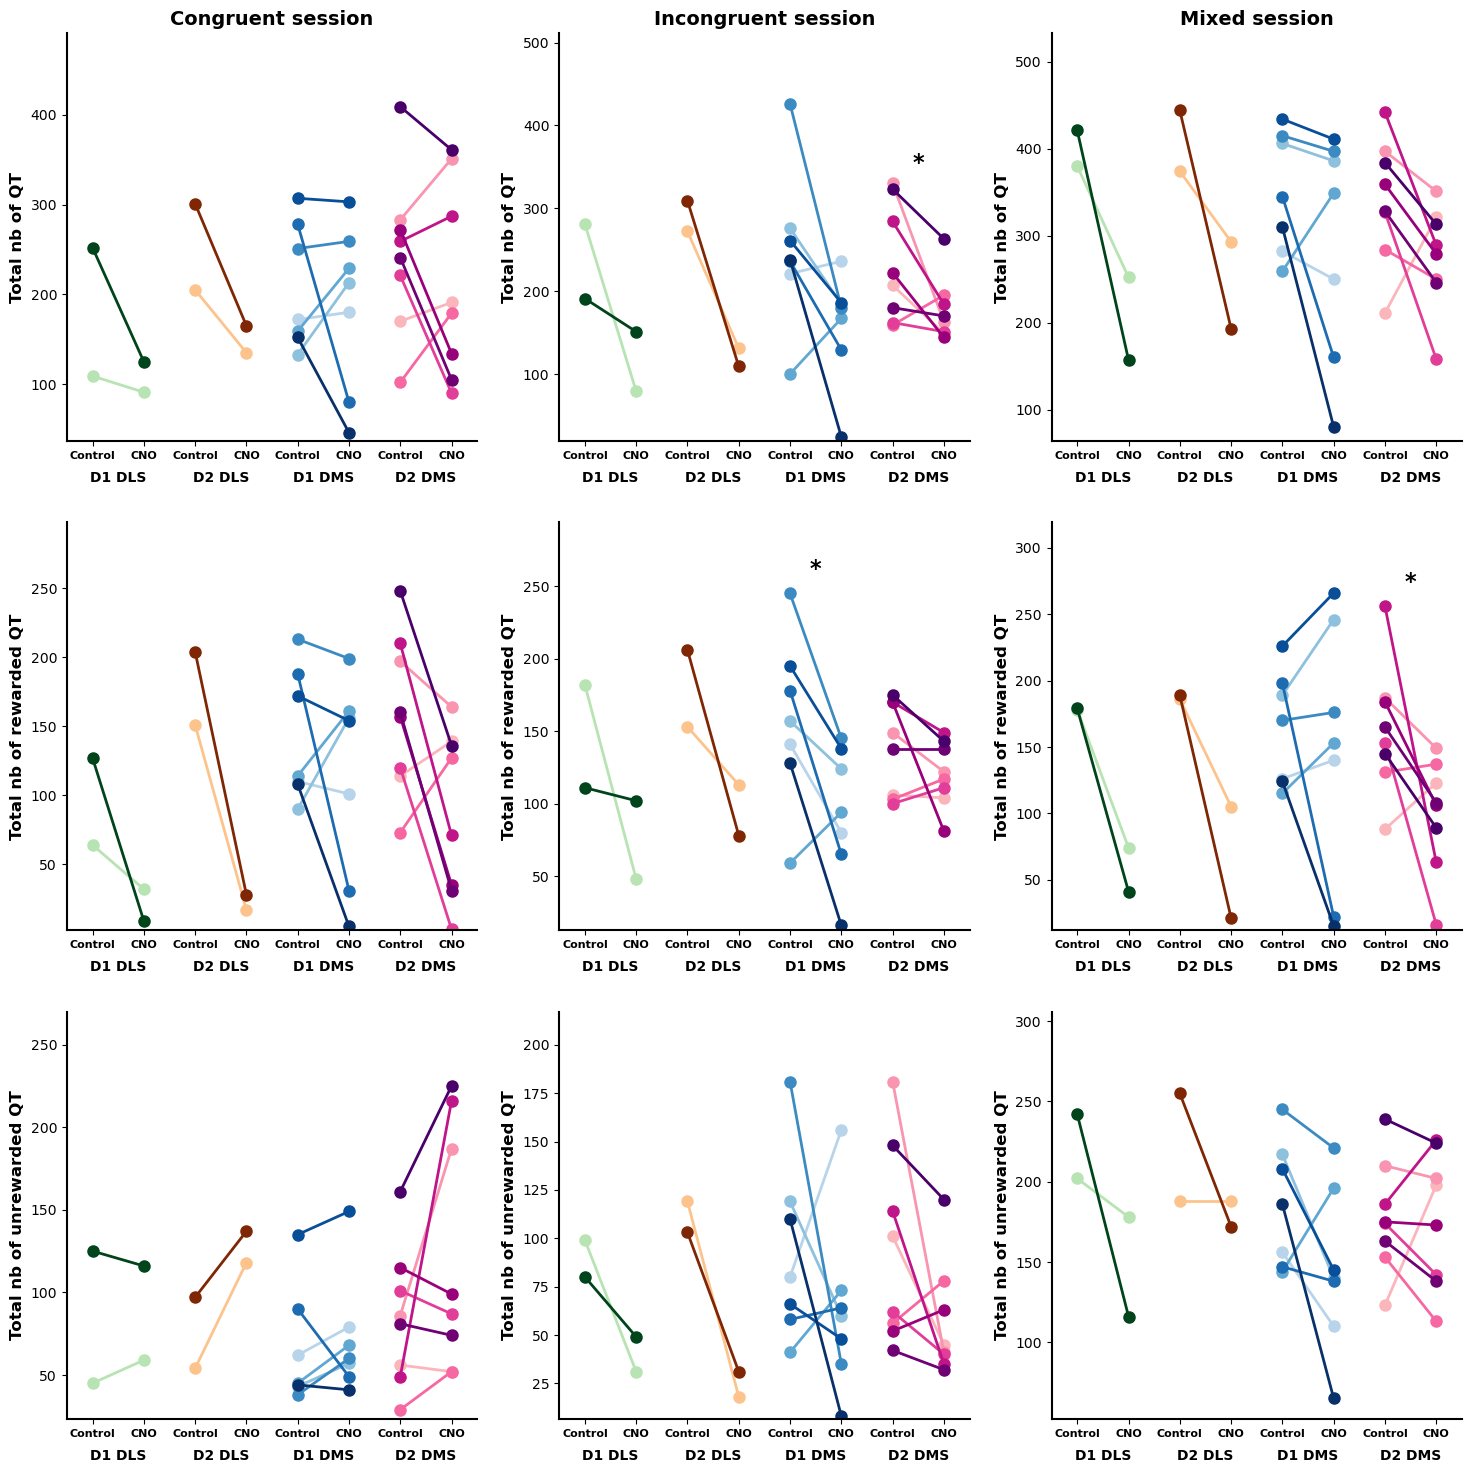

In [ ]:
# Plot number of QT/rewarded/unrewarded with plot_metric_comparison_by_group

fig, axs = plt.subplots(3,3,figsize=(18, 18))
plot_metric_comparison_by_group(axs[0,0], total_QT_dict, "Total nb of QT", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[0,1], total_QT_dict, "Total nb of QT", groups, bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[0,2], total_QT_dict, "Total nb of QT", groups, bias_direction="Mixed")

plot_metric_comparison_by_group(axs[1,0], total_QT_rewarded_dict, "Total nb of rewarded QT", groups, set_title=False, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1,1], total_QT_rewarded_dict, "Total nb of rewarded QT", groups, set_title=False,bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[1,2], total_QT_rewarded_dict, "Total nb of rewarded QT", groups, set_title=False,bias_direction="Mixed")

plot_metric_comparison_by_group(axs[2,0], total_QT_unrewarded_dict, "Total nb of unrewarded QT", groups, set_title=False,bias_direction="Congruent")
plot_metric_comparison_by_group(axs[2,1], total_QT_unrewarded_dict, "Total nb of unrewarded QT", groups, set_title=False,bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[2,2], total_QT_unrewarded_dict, "Total nb of unrewarded QT", groups, set_title=False,bias_direction="Mixed")

plt.show()

D1 DMS Incongruent (Total nb of CW QT) - Statistique de Wilcoxon: 1.0, p-value: 0.0312
D2 DMS Congruent (Total nb of CCW QT) - Statistique de Wilcoxon: 3.0, p-value: 0.0391
D2 DMS Congruent (Ratio (CW-CCW)/(CW+CCW)) - Statistique de Wilcoxon: 3.0, p-value: 0.0391
D2 DMS Congruent (Success %age) - Statistique de Wilcoxon: 2.0, p-value: 0.0234


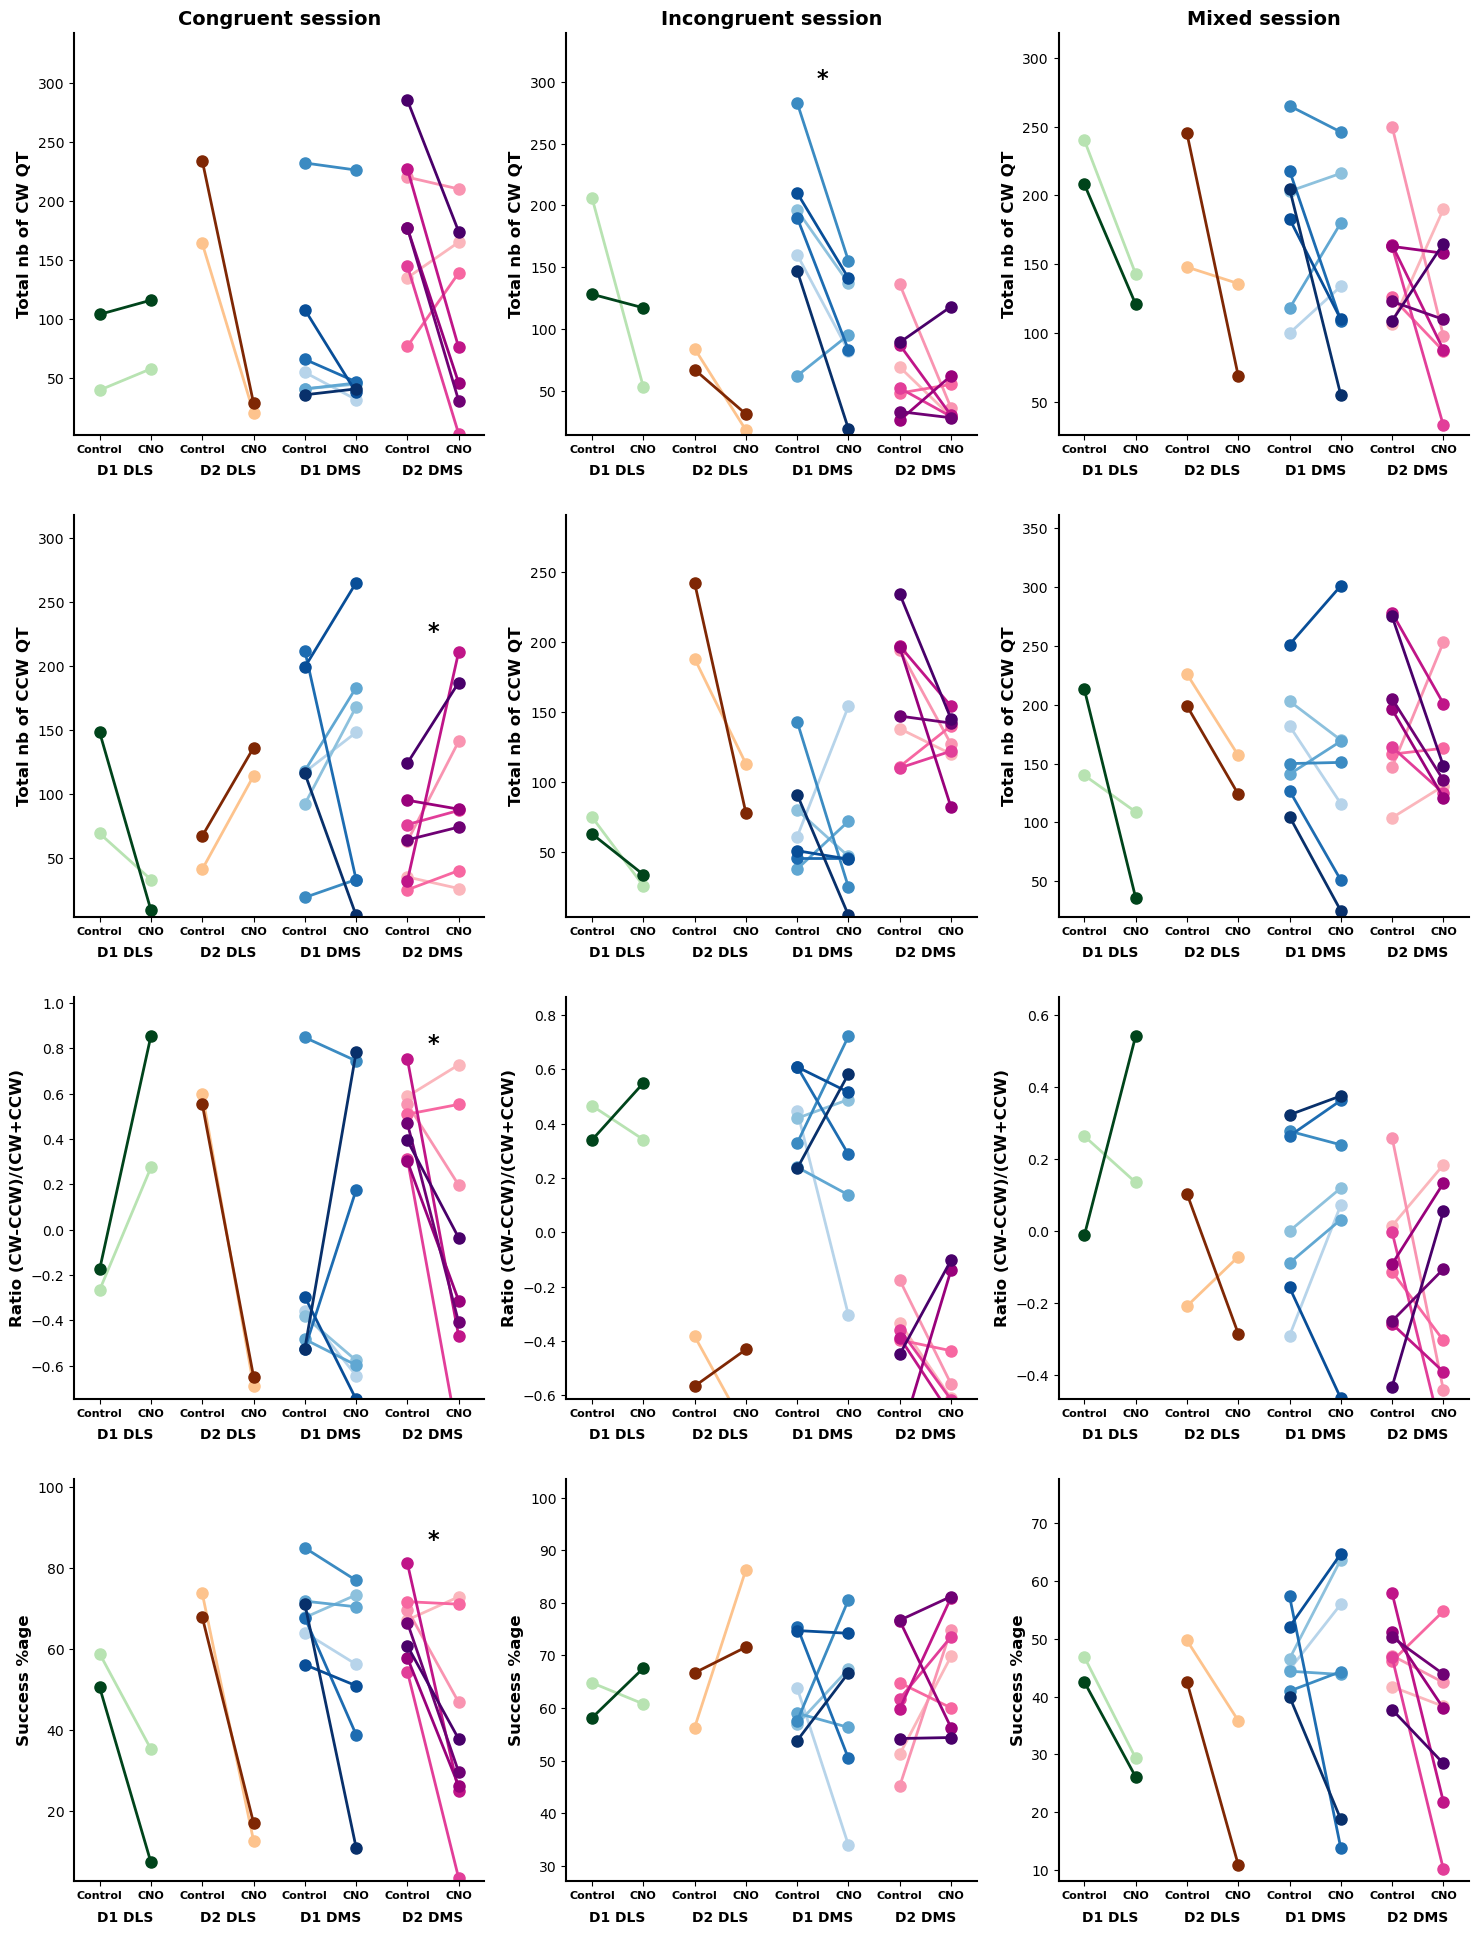

In [ ]:
# Plot CW/CCW/ratio/%age of success with plot_metric_comparison_by_group

fig, axs = plt.subplots(4,3,figsize=(18, 24))
plot_metric_comparison_by_group(axs[0,0], total_CW_dict, "Total nb of CW QT", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[0,1], total_CW_dict, "Total nb of CW QT", groups, bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[0,2], total_CW_dict, "Total nb of CW QT", groups, bias_direction="Mixed")

plot_metric_comparison_by_group(axs[1,0], total_CCW_dict, "Total nb of CCW QT", groups, set_title=False, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1,1], total_CCW_dict, "Total nb of CCW QT", groups, set_title=False,bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[1,2], total_CCW_dict, "Total nb of CCW QT", groups, set_title=False,bias_direction="Mixed")

plot_metric_comparison_by_group(axs[2,0], ratio_CW_CCW_dict, "Ratio (CW-CCW)/(CW+CCW)", groups, set_title=False,bias_direction="Congruent")
plot_metric_comparison_by_group(axs[2,1], ratio_CW_CCW_dict, "Ratio (CW-CCW)/(CW+CCW)", groups, set_title=False,bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[2,2], ratio_CW_CCW_dict, "Ratio (CW-CCW)/(CW+CCW)", groups, set_title=False,bias_direction="Mixed")

plot_metric_comparison_by_group(axs[3,0], percentage_rewarded_dict, "Success %age", groups, set_title=False,bias_direction="Congruent")
plot_metric_comparison_by_group(axs[3,1], percentage_rewarded_dict, "Success %age", groups, set_title=False,bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[3,2], percentage_rewarded_dict, "Success %age", groups, set_title=False,bias_direction="Mixed")

plt.show()

In [ ]:
# Dictionary to store rewarded directions per session and per mouse
rewarded_direction_per_session = {}

# Browse each mouse in the mouse list
for mouse in mice_list:
    rewarded_direction_per_session[mouse] = {}  # Initialize the subdictionary for each mouse
    
    # Browse each session of this mouse
    for session_index, session_name in enumerate(session_list[mouse]):
        # Build the path to the CSV file
        csv_file_path = os.path.join(path_to_data_folder, mouse, session_name, f"{session_name}_sessionparam.csv")
        
        # Read the CSV file to get the potentialRewardedDirections column
        try:
            session_data = pd.read_csv(csv_file_path)
            rewarded_directions = session_data["potentialRewardedDirections"].iloc[0]
            
            # Decoding the rewarded direction
            if rewarded_directions == "[90]":
                direction = "CCW"
            elif rewarded_directions == "[270]":
                direction = "CW"
            else:
                direction = "both"
            
            # Add this information to the dictionary
            rewarded_direction_per_session[mouse][session_index] = direction

        except FileNotFoundError:
            print(f"Fichier {csv_file_path} non trouvé.")
        except Exception as e:
            print(f"Erreur lors de la lecture de {csv_file_path}: {e}")

In [ ]:
# Dictionary to store percentage of success (turns in rewarded direction)

success_percentage_dict = {}

for mouse in mice_list:
    success_percentage_dict[mouse] = {}

    # Browse each mouse session
    for session_index, session_name in enumerate(session_list[mouse]):
        # Recover the rewarded management of the session
        rewarded_direction = rewarded_direction_per_session[mouse].get(session_index, "both")
        
        # Retrieve results for CW and CCW
        total_CW = run_around_tower_results_dict[mouse][session_index]['All']['total_CW']
        total_CCW = run_around_tower_results_dict[mouse][session_index]['All']['total_CCW']
        
        # Calculate the percentages for CW and CCW
        if total_CW + total_CCW > 0:  # Avoid division by zero
            percentage_CW = round((total_CW / (total_CW + total_CCW)) * 100, 2)
            percentage_CCW = round((total_CCW / (total_CW + total_CCW)) * 100, 2)
        else:
            percentage_CW = percentage_CCW = 0  # If no run, success percentage is 0
            
        # Select the percentage based on the direction rewarded
        if rewarded_direction == "both":
            success_percentage = percentage_rewarded_dict[mouse][session_index]
        elif rewarded_direction == "CW":
            success_percentage = percentage_CW
        elif rewarded_direction == "CCW":
            success_percentage = percentage_CCW
        else:
            print(f"No rewarded direction defined for session {session_index}")
            success_percentage = 0  # Default case if an unexpected value is present

        # Add to dictionary
        success_percentage_dict[mouse][session_index] = success_percentage

## Runs between towers (BT) analysis

#### Compare BT metrics between groups and before/after CNO injection

In [ ]:
# Dictionaries for storing the results of angular velocities of runs between towers
angular_speeds_BT = {}
median_angular_speed_BT = {}

# Loop for each animal
for mouse in mice_list:
    # Initializing dictionaries for the animal
    angular_speeds_BT[mouse] = {}
    median_angular_speed_BT[mouse] = {}

    # Loop for each session
    for session_index, session_name in enumerate(session_list[mouse]):
        
        # Initialize a list to store all angular velocities for runs between towers in this session
        session_angular_speeds = []
        
        # Extraction of runs between towers
        runs_between_towers = runs_between_towers_dict[mouse][session_index]
        
        # Loop for each run between towers
        for run in runs_between_towers:

            # Extracting the start and end indices of the run
            start_idx, end_idx = run[0]  # Indexes to extract data

            # Extraction of trajectory coordinates and time for the run
            X_run = X_positions_dict[mouse][session_index][start_idx:end_idx]
            Y_run = Y_positions_dict[mouse][session_index][start_idx:end_idx]
            time_run = traject_time_dict[mouse][session_index][start_idx:end_idx]

            # Verify that the extracted data is valid
            if len(X_run) > 1 and len(Y_run) > 1 and len(time_run) > 1:
                # Calculation of distances, speeds and angular velocities
                distances, speeds, angular_speeds = compute_distance_speed_angular_speed(
                    [X_run, Y_run], time_run
                )
                # Add angular velocities of runs to the session list
                session_angular_speeds.extend(angular_speeds)
            else:
                print(f"Run invalide pour la souris {mouse}, session {session_name}, indices ({start_idx}, {end_idx}).")

        # Storing session angular velocities in the dictionary
        angular_speeds_BT[mouse][session_index] = session_angular_speeds
        
        # Calculating the median angular velocities for this session
        if session_angular_speeds:  # Check if there are angular velocities to avoid errors
            median_angular_speed_BT[mouse][session_index] = np.nanmedian(session_angular_speeds)
        else:
            median_angular_speed_BT[mouse][session_index] = None  # If no angular velocity, median not calculable

D2 DMS Congruent (Median angular speed of BT) - Statistique de Wilcoxon: 1.0, p-value: 0.0156
D2 DMS Incongruent (Median angular speed of BT) - Statistique de Wilcoxon: 2.0, p-value: 0.0234


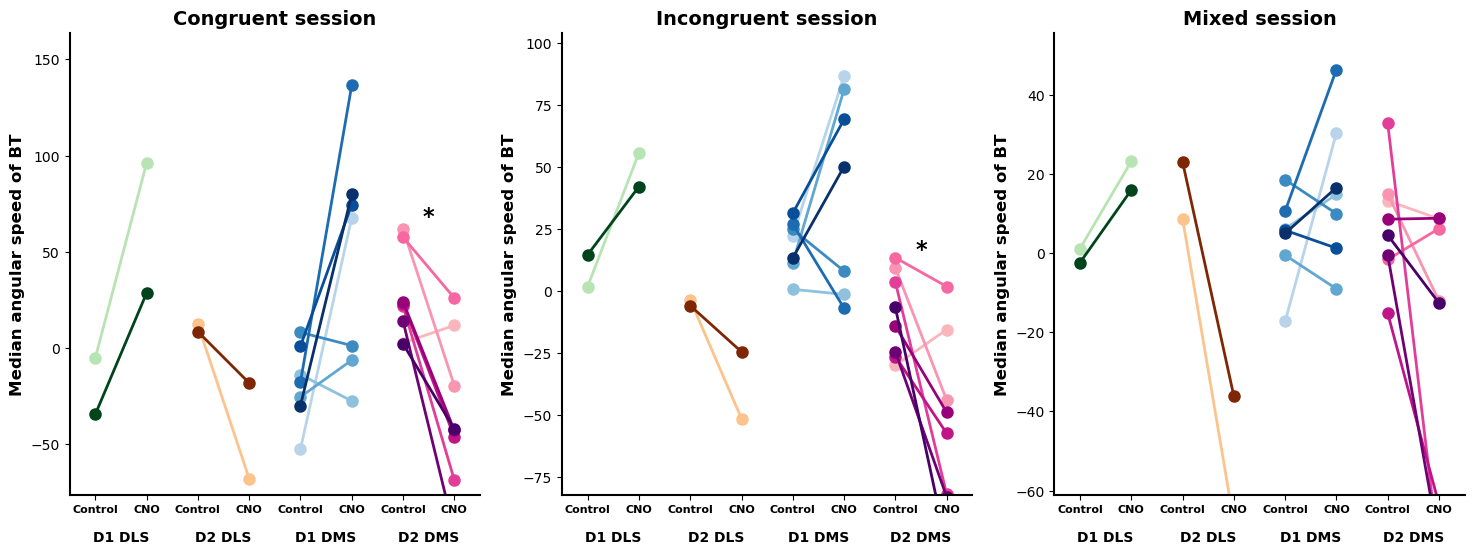

In [ ]:
# Plot angular speed of BT with plot_metric_comparison_by_group

fig, axs = plt.subplots(1,3,figsize=(18, 6))
plot_metric_comparison_by_group(axs[0], median_angular_speed_BT, "Median angular speed of BT", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1], median_angular_speed_BT, "Median angular speed of BT", groups, bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[2], median_angular_speed_BT, "Median angular speed of BT", groups, bias_direction="Mixed")

plt.show()

In [ ]:
# Retrieve distance, time, mean speed, max speed of BT
# Initialize counters and lists for run analysis

total_time_BT_dict = {}
total_distance_BT_dict = {}
meanspeed_BT_dict = {}
maxspeed_BT_dict = {}

for mouse in mice_list:
    total_time_BT_dict[mouse] = {}
    total_distance_BT_dict[mouse] = {}
    meanspeed_BT_dict[mouse] = {}
    maxspeed_BT_dict[mouse] = {}

    for session_index, session_name in enumerate(session_list[mouse]):

        total_time_BT = 0
        total_distance_BT = 0
        meanspeed_BT = []
        maxspeed_BT = []

        for run in runs_between_towers_dict[mouse][session_index]:
            start_index, end_index = run[0][0], run[0][1]
            run_X_position = X_positions_dict[mouse][session_index][start_index:end_index + 1]
            run_Y_position = Y_positions_dict[mouse][session_index][start_index:end_index + 1]
            run_duration = traject_time_dict[mouse][session_index][end_index] - traject_time_dict[mouse][session_index][start_index]
            distance_ran = np.sum(distances_dict[mouse][session_index][start_index:end_index])

            # Accumulate metrics
            total_time_BT += run_duration
            total_distance_BT += distance_ran
            meanspeed_BT.append(distance_ran / run_duration)
            maxspeed_BT.append(np.max(speeds_dict[mouse][session_index][start_index:end_index]))

        # Store results for this session in the dictionaries
        total_time_BT_dict[mouse][session_index] = total_time_BT
        total_distance_BT_dict[mouse][session_index] = total_distance_BT
        meanspeed_BT_dict[mouse][session_index] = np.mean(meanspeed_BT)
        maxspeed_BT_dict[mouse][session_index] = np.max(maxspeed_BT)

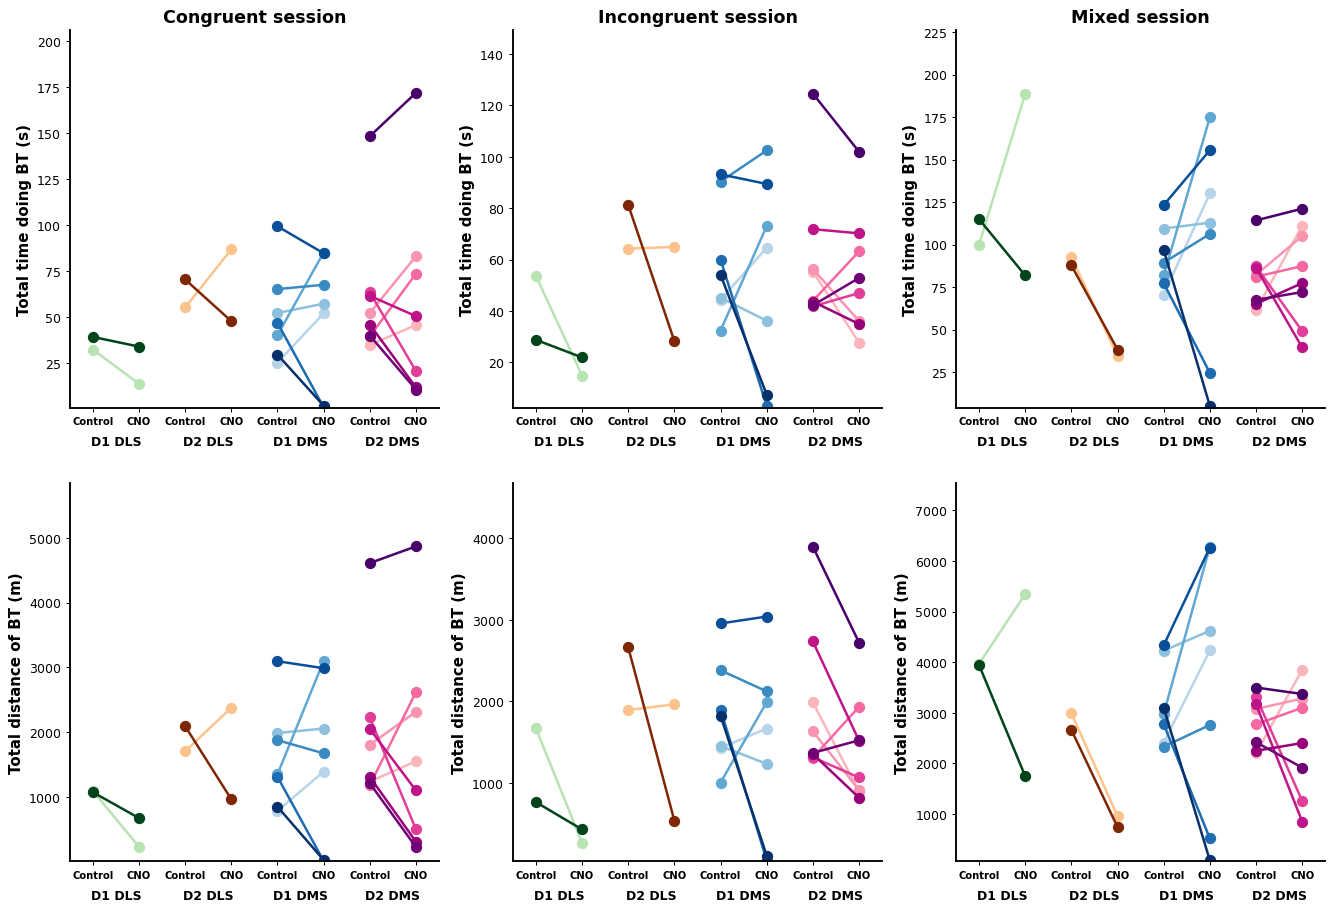

In [ ]:
# Plot time/distance of BT with plot_metric_comparison_by_group

fig, axs = plt.subplots(2,3,figsize=(18, 12), dpi=90)

plot_metric_comparison_by_group(axs[0,0], total_time_BT_dict, "Total time doing BT (s)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[0,1], total_time_BT_dict, "Total time doing BT (s)", groups, bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[0,2], total_time_BT_dict, "Total time doing BT (s)", groups, bias_direction="Mixed")

plot_metric_comparison_by_group(axs[1,0], total_distance_BT_dict, "Total distance of BT (m)", groups, set_title=False,bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1,1], total_distance_BT_dict, "Total distance of BT (m)", groups, set_title=False,bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[1,2], total_distance_BT_dict, "Total distance of BT (m)", groups, set_title=False,bias_direction="Mixed")

plt.show()

D2 DMS Incongruent (Mean speed BT (cm/s)) - Statistique de Wilcoxon: 1.0, p-value: 0.0156
D2 DMS Mixed (Mean speed BT (cm/s)) - Statistique de Wilcoxon: 1.0, p-value: 0.0156
D2 DMS Mixed (Max speed BT (cm/s)) - Statistique de Wilcoxon: 1.0, p-value: 0.0156


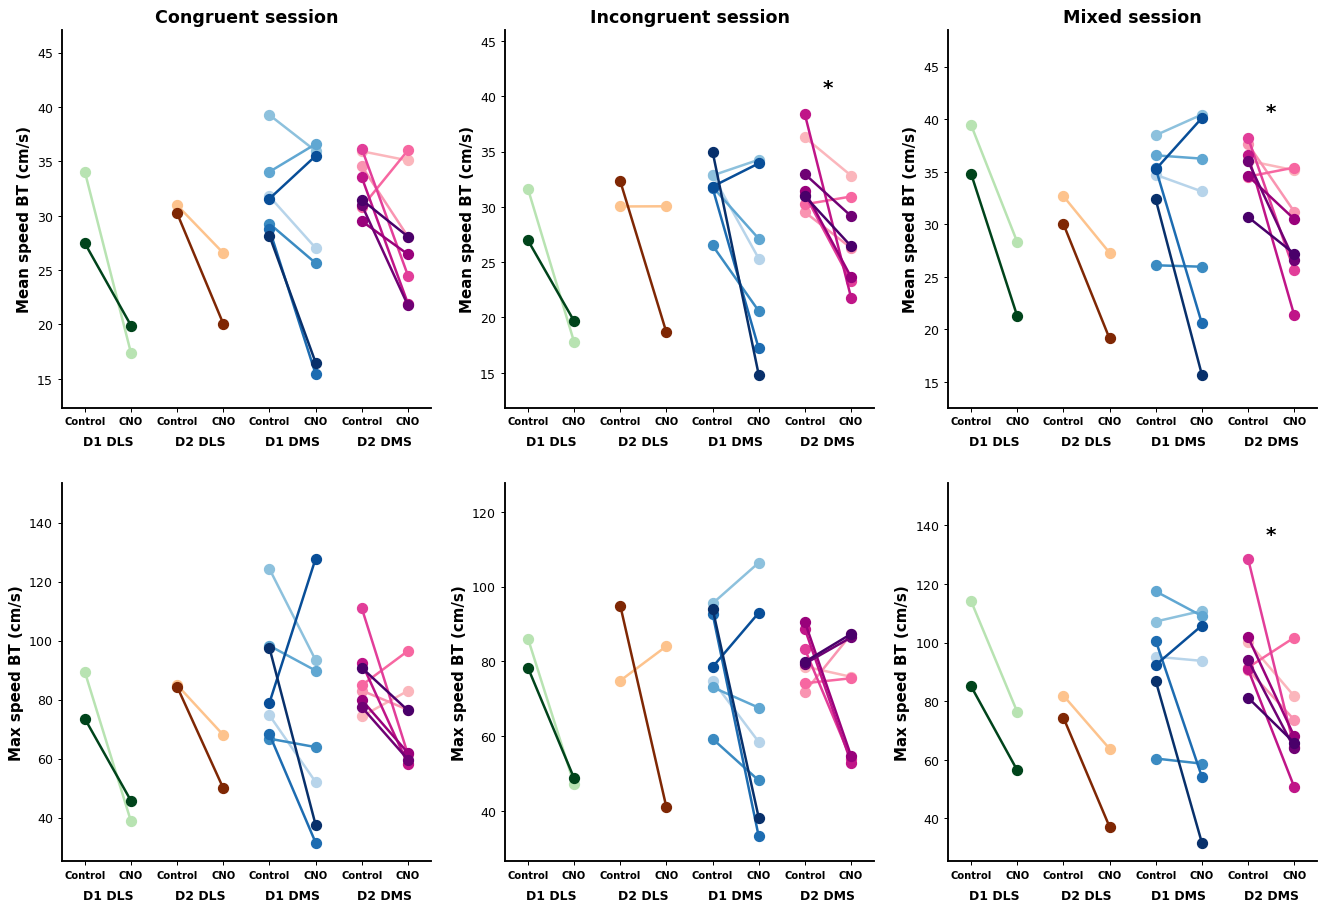

In [ ]:
# Plot speeds (mean/max) of BT with plot_metric_comparison_by_group

fig, axs = plt.subplots(2,3,figsize=(18, 12), dpi=90)

plot_metric_comparison_by_group(axs[0,0], meanspeed_BT_dict, "Mean speed BT (cm/s)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[0,1], meanspeed_BT_dict, "Mean speed BT (cm/s)", groups, bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[0,2], meanspeed_BT_dict, "Mean speed BT (cm/s)", groups, bias_direction="Mixed")

plot_metric_comparison_by_group(axs[1,0], maxspeed_BT_dict, "Max speed BT (cm/s)", groups, set_title=False, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1,1], maxspeed_BT_dict, "Max speed BT (cm/s)", groups, set_title=False,bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[1,2], maxspeed_BT_dict, "Max speed BT (cm/s)", groups, set_title=False,bias_direction="Mixed")

plt.show()

## Exploratory runs (ER) analysis

#### Compare ER metrics between groups and before/after CNO injection

In [ ]:
# Retrieve distance, time, mean speed, max speed of ER
# Initialize counters and lists for run analysis

total_time_ER_dict = {}
total_distance_ER_dict = {}
meanspeed_ER_dict = {}
maxspeed_ER_dict = {}

for mouse in mice_list:

    total_time_ER_dict[mouse] = {}
    total_distance_ER_dict[mouse] = {}
    meanspeed_ER_dict[mouse] = {}
    maxspeed_ER_dict[mouse] = {}

    for session_index, session_name in enumerate(session_list[mouse]):

        total_time_ER = 0
        total_distance_ER = 0
        meanspeed_ER = []
        maxspeed_ER = []

        for run in exploratory_runs_dict[mouse][session_index]:
            start_index, end_index = run[0][0], run[0][1]
            run_X_position = X_positions_dict[mouse][session_index][start_index:end_index + 1]
            run_Y_position = Y_positions_dict[mouse][session_index][start_index:end_index + 1]
            run_duration = traject_time_dict[mouse][session_index][end_index] - traject_time_dict[mouse][session_index][start_index]
            distance_ran = np.sum(distances_dict[mouse][session_index][start_index:end_index])

            # Accumulate metrics
            total_time_ER += run_duration
            total_distance_ER += distance_ran
            meanspeed_ER.append(distance_ran / run_duration)
            maxspeed_ER.append(np.max(speeds_dict[mouse][session_index][start_index:end_index]))

        # Store results for this session in the dictionaries
        total_time_ER_dict[mouse][session_index] = total_time_ER
        total_distance_ER_dict[mouse][session_index] = total_distance_ER
        meanspeed_ER_dict[mouse][session_index] = np.mean(meanspeed_ER)
        maxspeed_ER_dict[mouse][session_index] = np.max(maxspeed_ER)

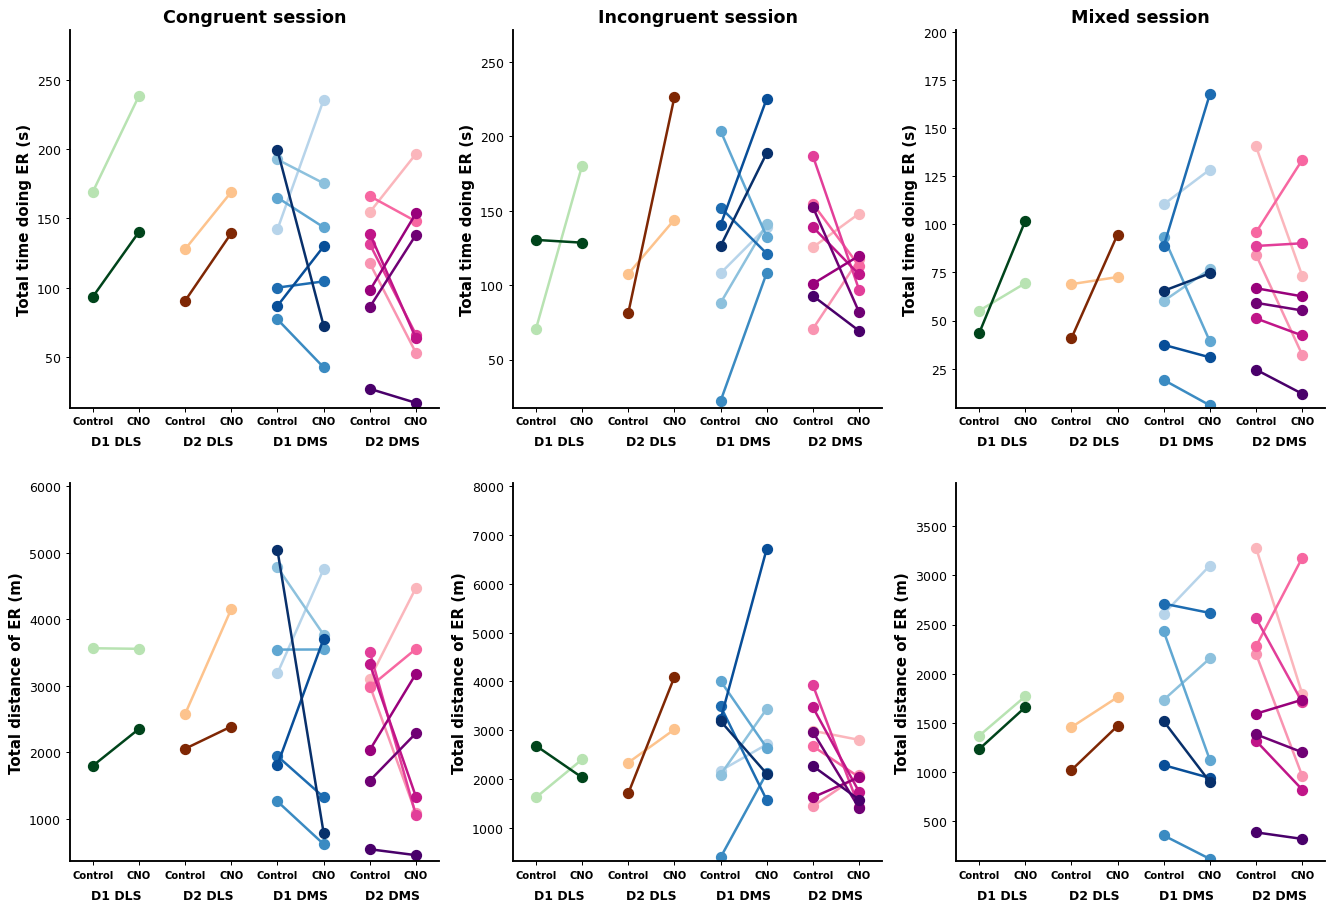

In [ ]:
# Plot time/distance of ER with plot_metric_comparison_by_group

fig, axs = plt.subplots(2,3,figsize=(18, 12), dpi=90)

plot_metric_comparison_by_group(axs[0,0], total_time_ER_dict, "Total time doing ER (s)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[0,1], total_time_ER_dict, "Total time doing ER (s)", groups, bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[0,2], total_time_ER_dict, "Total time doing ER (s)", groups, bias_direction="Mixed")

plot_metric_comparison_by_group(axs[1,0], total_distance_ER_dict, "Total distance of ER (m)", groups, set_title=False,bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1,1], total_distance_ER_dict, "Total distance of ER (m)", groups, set_title=False,bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[1,2], total_distance_ER_dict, "Total distance of ER (m)", groups, set_title=False,bias_direction="Mixed")

plt.show()

D2 DMS Incongruent (Mean speed ER (cm/s)) - Statistique de Wilcoxon: 3.0, p-value: 0.0391


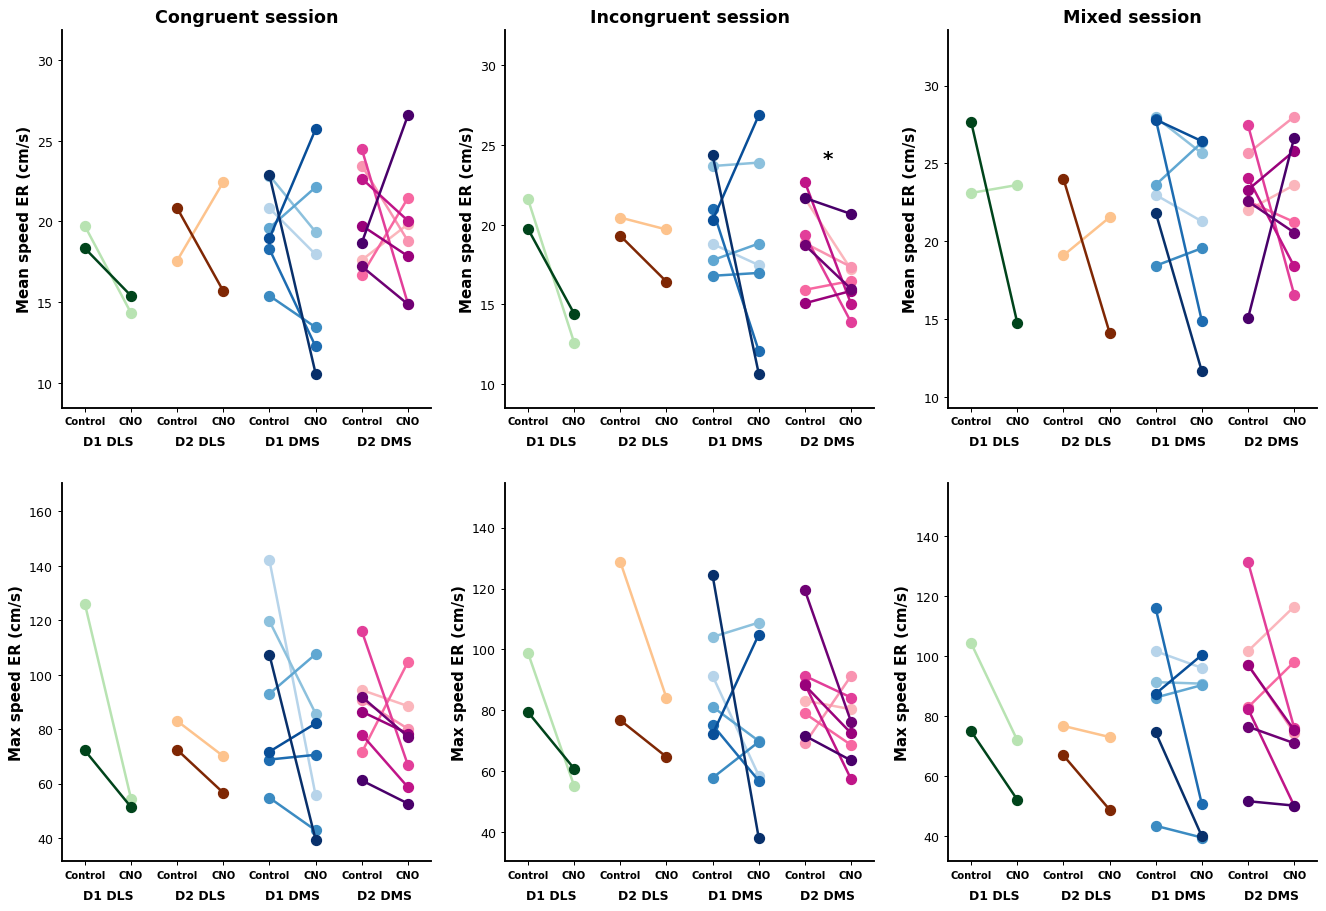

In [ ]:
# Plot speeds (mean/max) of ER with plot_metric_comparison_by_group

fig, axs = plt.subplots(2,3,figsize=(18, 12), dpi=90)

plot_metric_comparison_by_group(axs[0,0], meanspeed_ER_dict, "Mean speed ER (cm/s)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[0,1], meanspeed_ER_dict, "Mean speed ER (cm/s)", groups, bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[0,2], meanspeed_ER_dict, "Mean speed ER (cm/s)", groups, bias_direction="Mixed")

plot_metric_comparison_by_group(axs[1,0], maxspeed_ER_dict, "Max speed ER (cm/s)", groups, set_title=False, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1,1], maxspeed_ER_dict, "Max speed ER (cm/s)", groups, set_title=False,bias_direction="Incongruent")
plot_metric_comparison_by_group(axs[1,2], maxspeed_ER_dict, "Max speed ER (cm/s)", groups, set_title=False,bias_direction="Mixed")

plt.show()

## Other functions to compare metrics between groups

#### Compare metrics between groups along 4 sessions (Control/CNO, morning/afternoon)

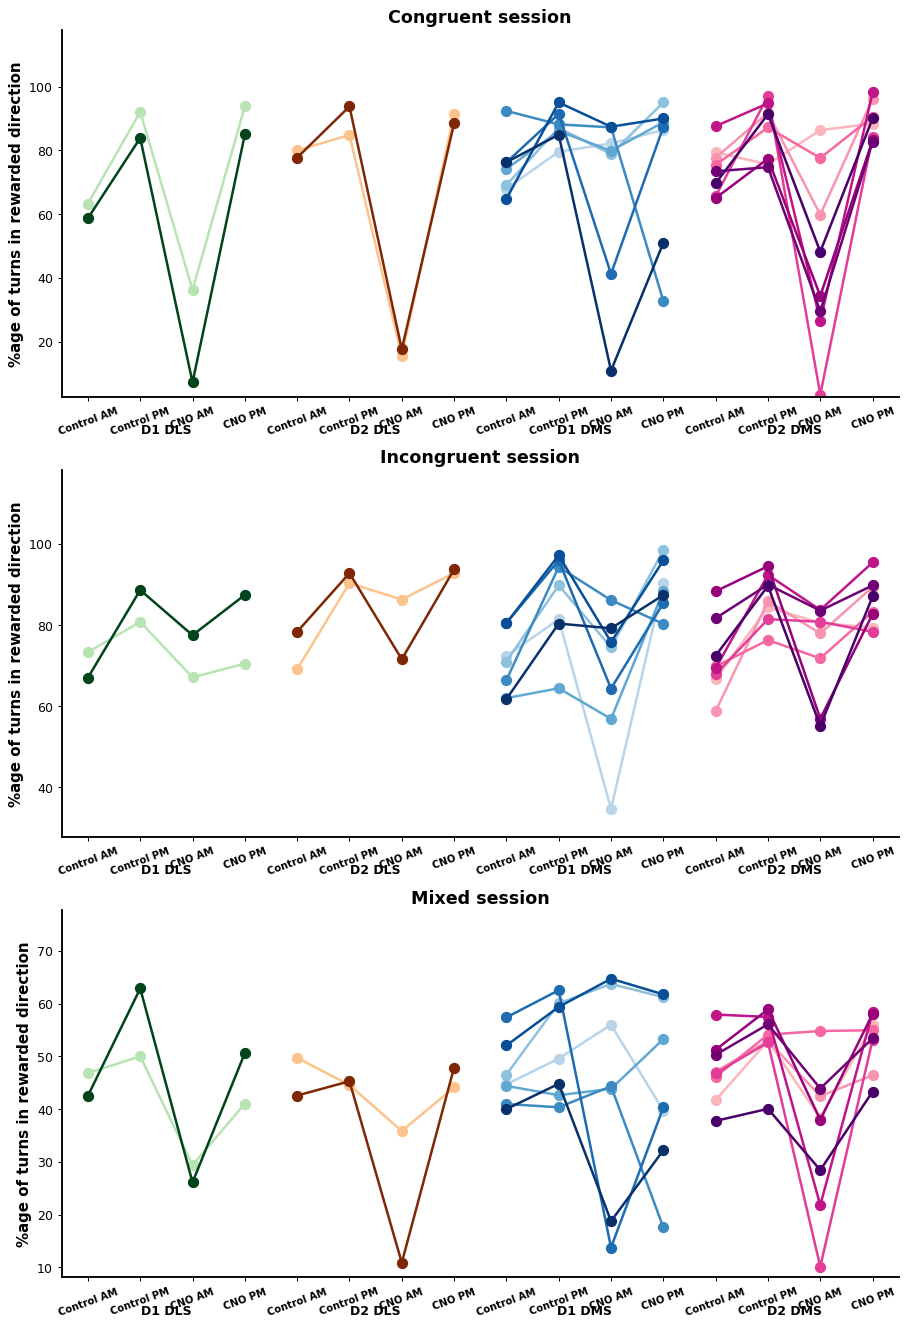

In [ ]:
# Function to plot a metric in control vs CNO session (morning vs afternoon)

def plot_metric_by_group_4sessions(ax, metric_dict, metric_name, groups, set_title=True, bias_direction="congruent"):
    """
    Compares a metric before and after CNO injection for each group, with an improved display.
    This version displays 4 sessions: "Control AM", "Control PM", "CNO AM", "CNO PM".

    :param ax: Matplotlib axis on which to draw the graph.
    :param metric_dict: Dictionary of metrics for each mouse.
    :param metric_name: Name of the metric to display on the Y axis.
    :param groups: Dictionary of mouse groups (group name → list of mice).
    :param bias_direction: "congruent", "incongruent", or "mixed".
    """

    # Selection of CNO sessions based on bias
    if bias_direction == "Mixed":
        session_cno_am_selected = {mouse: session_cno_indices["cno_third"] for mouse in mice_list}
    else:
        session_cno_am_selected = {
            mouse: session_cno_indices["cno_second"] if mouse in batch_starting_incongruent 
            else session_cno_indices["cno_first"]
            for mouse in mice_list
        } if bias_direction == "Congruent" else {
            mouse: session_cno_indices["cno_first"] if mouse in batch_starting_incongruent 
            else session_cno_indices["cno_second"]
            for mouse in mice_list
        }

    session_control_am_selected = {mouse: idx - 4 for mouse, idx in session_cno_am_selected.items()}
    session_control_pm_selected = {mouse: idx - 3 for mouse, idx in session_cno_am_selected.items()}
    session_cno_pm_selected = {mouse: idx + 1 for mouse, idx in session_cno_am_selected.items()}

    tick_positions = []
    session_labels = []
    group_annotations = []
    
    all_data = []

    # Loop through each group to retrieve the data and plot the points
    for i, (group_name, group_mice) in enumerate(groups.items()):
        group_control_am_data = []
        group_control_pm_data = []
        group_cno_am_data = []
        group_cno_pm_data = []
        
        cmap = plt.get_cmap(colormaps.get(group_name))  # Group-specific colormap
        colors = cmap(np.linspace(0.3, 1, len(group_mice)))  # Color gradient for group mice
        
        for j, mouse in enumerate(group_mice):
            if mouse in metric_dict:
                if (
                    session_control_am_selected[mouse] in metric_dict[mouse] and 
                    session_control_pm_selected[mouse] in metric_dict[mouse] and
                    session_cno_am_selected[mouse] in metric_dict[mouse] and
                    session_cno_pm_selected[mouse] in metric_dict[mouse]
                ):
                    control_am = metric_dict[mouse][session_control_am_selected[mouse]]
                    control_pm = metric_dict[mouse][session_control_pm_selected[mouse]]
                    cno_am = metric_dict[mouse][session_cno_am_selected[mouse]]
                    cno_pm = metric_dict[mouse][session_cno_pm_selected[mouse]]

                    group_control_am_data.append(control_am)
                    group_control_pm_data.append(control_pm)
                    group_cno_am_data.append(cno_am)
                    group_cno_pm_data.append(cno_pm)
                    all_data.extend([control_am, control_pm, cno_am, cno_pm])

                    # Positions on the X axis
                    control_am_pos = i * 4
                    control_pm_pos = i * 4 + 1
                    cno_am_pos = i * 4 + 2
                    cno_pm_pos = i * 4 + 3

                    # Drawing lines and points
                    ax.plot([control_am_pos, control_pm_pos, cno_am_pos, cno_pm_pos], 
                            [control_am, control_pm, cno_am, cno_pm], 
                            color=colors[j], linewidth=2, linestyle='-', marker='o', markersize=8)

        # Added positions and labels for the X axis
        tick_positions.extend([i * 4, i * 4 + 1, i * 4 + 2, i * 4 + 3])
        session_labels.extend(["Control AM", "Control PM", "CNO AM", "CNO PM"])

        # Add group annotation
        group_annotations.append((i * 4 + 1.5, group_name))

    # Axis configuration
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(session_labels, fontsize=10, fontweight='bold', rotation=20)

    # Displaying group names below pairs of points
    for pos, group_name in group_annotations:
        ax.annotate(group_name, xy=(pos, -0.1), xycoords=('data', 'axes fraction'), ha='center', fontsize=10, fontweight='bold')

    if set_title:
        ax.set_title(f"{bias_direction} session", fontsize=14, fontweight='bold')
    ax.set_ylabel(metric_name, fontsize=12, fontweight='bold')

    # Automatic definition of ylim with a 20% margin
    if all_data:
        ax.set_ylim(min(all_data) * 0.8, max(all_data) * 1.2)

    ax.set_xlim(-0.5, len(groups) * 4 - 0.5)

    # Removed grids for a cleaner display
    ax.grid(False)

    # Customizing the axes
    ax.tick_params(axis='y', which='major', labelsize=10)
    ax.tick_params(axis='x', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

# Example of use
fig, axs = plt.subplots(3 ,1, figsize=(12, 18), dpi=90)
plot_metric_by_group_4sessions(axs[0], success_percentage_dict, "%age of turns in rewarded direction", groups, bias_direction="Congruent")
plot_metric_by_group_4sessions(axs[1], success_percentage_dict, "%age of turns in rewarded direction", groups, bias_direction="Incongruent")
plot_metric_by_group_4sessions(axs[2], success_percentage_dict, "%age of turns in rewarded direction", groups, bias_direction="Mixed")
plt.show()


🧪 D1 DMS: Wilcoxon test Congruent vs Mixed → p-value = 0.0312
🧪 D2 DMS: Wilcoxon test Congruent vs Incongruent → p-value = 0.0391
🧪 D2 DMS: Wilcoxon test Incongruent vs Mixed → p-value = 0.0078


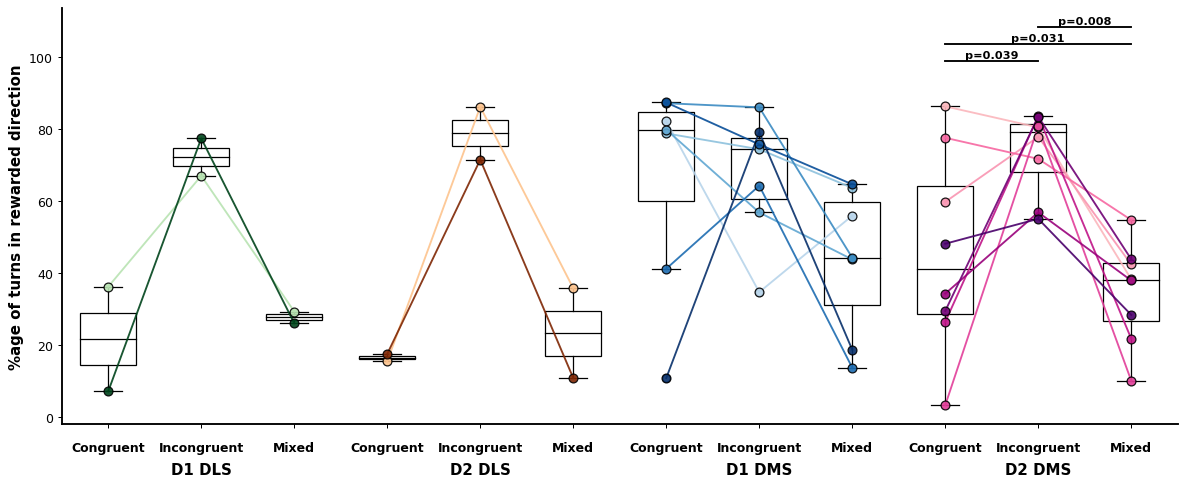

In [ ]:
def plot_metric_comparison_by_bias(ax, metric_dict, metric_name, groups):
    """
    Compares a metric between the Congruent, Incongruent, and Mixed sessions for each group.
    Adds boxplots without gray backgrounds, plots matching lines, and performs a Wilcoxon test.

    :param ax: Matplotlib axis on which to plot the graph.
    :param metric_dict: Dictionary containing the metric values ​​for each mouse.
    :param metric_name: Name of the metric to display on the Y axis.
    :param groups: Dictionary of mouse groups (group name → list of mice).
    """

    bias_conditions = ["Congruent", "Incongruent", "Mixed"]
    tick_positions = []
    group_annotations = []
    all_data = []
    scatter_data = []
    
    p_values = {}  # Store p-values ​​from Wilcoxon tests

    for i, (group_name, group_mice) in enumerate(groups.items()):
        cmap = plt.get_cmap(colormaps.get(group_name))  # Group-specific colormap
        colors = cmap(np.linspace(0.3, 1, len(group_mice)))  # Color gradient for group mice

        group_values = {bias: [] for bias in bias_conditions}
        individual_lines = {mouse: [] for mouse in group_mice}

        for j, mouse in enumerate(group_mice):
            if mouse in metric_dict:
                session_indices = {
                    "Congruent": (session_cno_indices["cno_second"] if mouse in batch_starting_incongruent 
                                  else session_cno_indices["cno_first"]),
                    "Incongruent": (session_cno_indices["cno_first"] if mouse in batch_starting_incongruent 
                                    else session_cno_indices["cno_second"]),
                    "Mixed": session_cno_indices["cno_third"]
                }

                for bias in bias_conditions:
                    session_idx = session_indices[bias]

                    if session_idx in metric_dict[mouse]:  
                        value = metric_dict[mouse][session_idx]  # Retrieving the value for this session
                        group_values[bias].append(value)
                        scatter_data.append((i * 3 + bias_conditions.index(bias), value, colors[j]))
                        individual_lines[mouse].append((i * 3 + bias_conditions.index(bias), value, colors[j]))

        # 🔹 Drawing lines connecting the same individuals across conditions
        for mouse, points in individual_lines.items():
            if len(points) == 3:  # Check that we have the 3 values ​​for this animal
                x_vals, y_vals, color = zip(*points)
                ax.plot(x_vals, y_vals, color=color[0], linewidth=1.5, alpha=0.9, zorder=2)

        # 📌 Adding boxplots
        data_boxplot = [group_values[bias] for bias in bias_conditions]
        ax.boxplot(data_boxplot, positions=[i * 3, i * 3 + 1, i * 3 + 2], widths=0.6, patch_artist=True, 
                   boxprops=dict(facecolor='white', color='black'), medianprops=dict(color='black'),
                   whiskerprops=dict(color='black'), capprops=dict(color='black'), zorder=1)

        # 🔬 Wilcoxon paired-rank test between biases
        pairs = [("Congruent", "Incongruent"), ("Congruent", "Mixed"), ("Incongruent", "Mixed")]
        for (bias1, bias2) in pairs:
            if len(group_values[bias1]) > 1 and len(group_values[bias2]) > 1:
                try:
                    stat, p_value = wilcoxon(group_values[bias1], group_values[bias2])
                    p_values[(group_name, bias1, bias2)] = p_value
                except ValueError:  # Error if data is identical
                    p_values[(group_name, bias1, bias2)] = 1.0

        tick_positions.extend([i * 3, i * 3 + 1, i * 3 + 2])
        group_annotations.append((i * 3 + 1, group_name))

    # 🔹 Displaying individual points
    for x, y, color in scatter_data:
        ax.scatter(x, y, color=color, edgecolor='black', s=50, alpha=0.9, zorder=2)

    # 🔹 Add p-values ​​to the graph if significant
    y_max_group = max(max(group_values["Congruent"]), max(group_values["Incongruent"]), max(group_values["Mixed"])) * 1.1
    height_offset = {("Congruent", "Incongruent"): 1.05, ("Congruent", "Mixed"): 1.10, ("Incongruent", "Mixed"): 1.15}
    for (group, bias1, bias2), p_value in p_values.items():
        if p_value <= 0.05:
            x_pos1 = i * 3 + bias_conditions.index(bias1)
            x_pos2 = i * 3 + bias_conditions.index(bias2)
            heigh_p_value = y_max_group * height_offset[(bias1, bias2)]
            ax.plot([x_pos1, x_pos2], [heigh_p_value-0.9, heigh_p_value-0.9], color='black', linewidth=1.5)
            ax.text((x_pos1 + x_pos2) / 2, heigh_p_value, f"p={p_value:.3f}", ha='center', fontsize=9, fontweight='bold')


    # 🔹 Axis configuration
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(bias_conditions * len(groups), fontsize=10, fontweight='bold', rotation=0, ha='center')
    ax.xaxis.set_tick_params(pad=10)  # Increases the vertical spacing between ticks and the X axis

    # 🔹 Added group labels at the bottom
    for pos, group_name in group_annotations:
        ax.annotate(group_name, xy=(pos, -0.12), xycoords=('data', 'axes fraction'), ha='center', fontsize=12, fontweight='bold')

    ax.set_ylabel(metric_name, fontsize=12, fontweight='bold')
    # ax.set_title(f"Comparison of {metric_name} across bias conditions", fontsize=14, fontweight='bold')

    # 🔹 Y scale adjustment
    if all_data:
        ax.set_ylim(min(all_data) * 0.8, max(all_data) * 1.2)

    ax.set_xlim(-0.5, len(groups) * 3 - 0.5)

    # 🔹 Removed grids for a cleaner display
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    # 🔬 Displaying p-values ​​in the console
    for (group, bias1, bias2), p_value in p_values.items():
        if p_value <= 0.05:
            print(f"🧪 {group}: Wilcoxon test {bias1} vs {bias2} → p-value = {p_value:.4f}")

# 📊 Example of use
fig, ax = plt.subplots(figsize=(16, 6), dpi=90)
plot_metric_comparison_by_bias(ax, 
                               metric_dict=success_percentage_dict, 
                               metric_name="%age of turns in rewarded direction", 
                               groups=groups)
plt.show()
